In [0]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


import tensorflow_datasets as tfds

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
class_names = ['cloud', 'fire', 'smoke', 'regular']

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names) #nb_classes = 4

IMAGE_SIZE = (232, 232)

In [0]:
# !unzip /images.zip

In [0]:
def load_data():
    """
        Load the data:
           
    """
    
    datasets = ['images/train', 'images/test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            curr_label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                curr_img = cv2.imread(img_path)
                curr_img = cv2.resize(curr_img, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(curr_img)
                labels.append(curr_label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [0]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading images/train
Loading images/test


In [0]:
train_images, train_labels = shuffle(train_images, train_labels)

In [0]:
print ("Number of training examples: " + str(train_labels.shape[0]))
print ("Number of testing examples: " + str(test_labels.shape[0]))
print ("Each image is of size: " + str(train_images.shape[1:]))

Number of training examples: 955
Number of testing examples: 246
Each image is of size: (232, 232, 3)


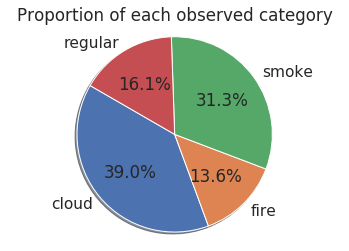

In [0]:
# Plot a pie chart
sizes = np.bincount(train_labels)
explode = (0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion of each observed category')

plt.show()

In [0]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [0]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow((images[index]*255).astype(np.uint8))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

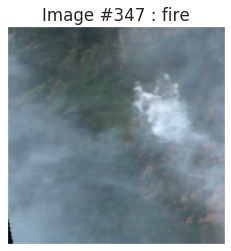

In [0]:
display_random_image(class_names, train_images, train_labels)


In [0]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

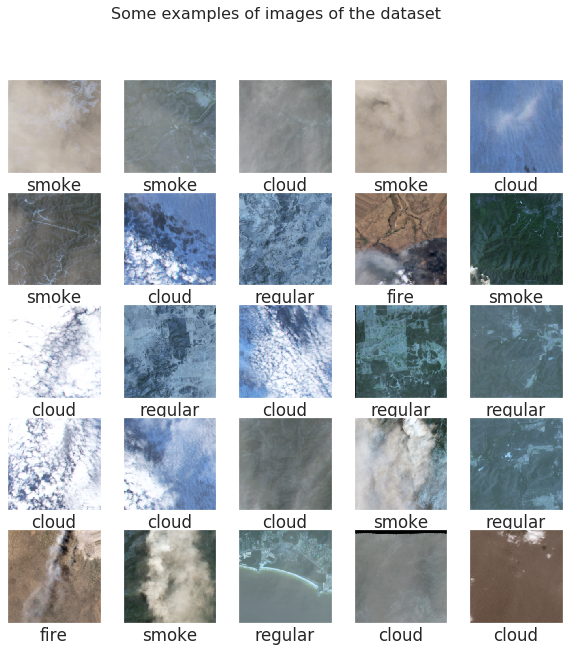

In [0]:
display_examples(class_names, train_images, train_labels)


In [0]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

In [0]:
inChannel = 3
input_img = Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], inChannel))

In [0]:
def autoencoder_func(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #7 x 7 x 64
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #7 x 7 x 128 (small and thick)

    #decoder
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv5) # 14 x 14 x 128
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1) #7 x 7 x 128
    up2 = UpSampling2D((2,2))(conv6) # 14 x 14 x 128    
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2) # 14 x 14 x 64
    up3 = UpSampling2D((2,2))(conv7) # 28 x 28 x 64
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3) # 28 x 28 x 1

    return decoded

In [0]:
autoencoder = Model(input_img, autoencoder_func(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [0]:
autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 232, 232, 3)]     0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 232, 232, 32)      896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 116, 116, 32)      0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 58, 58, 128)       73856     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 29, 29, 128)       0  

In [0]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_images,
                                                             train_images, 
                                                             test_size=0.2, 
                                                             random_state=42)

In [0]:
batch_size = 32
epochs = 3
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,
                                    verbose=1,validation_data=(valid_X, valid_ground))

Train on 764 samples, validate on 191 samples
Epoch 1/3
764/764 [==============================] - 496s 649ms/sample - loss: 0.0540 - val_loss: 0.0428
Epoch 2/3
764/764 [==============================] - 491s 642ms/sample - loss: 0.0424 - val_loss: 0.0420
Epoch 3/3
764/764 [==============================] - 494s 647ms/sample - loss: 0.0422 - val_loss: 0.0400


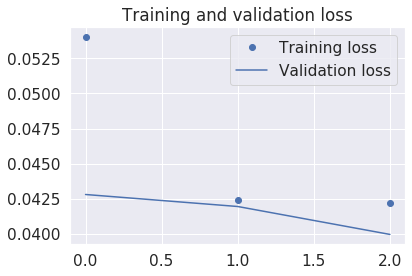

In [0]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
pred = autoencoder.predict(test_images)

Test Images


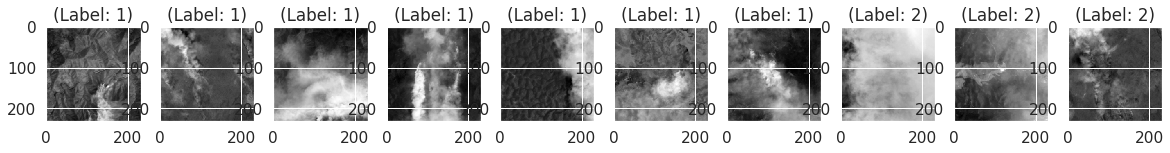

Reconstruction of Noisy Test Images


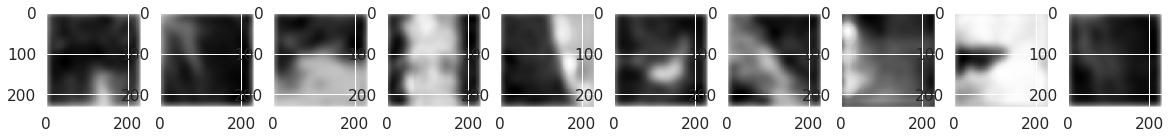

In [0]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_images[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(curr_lbl) + ")")
plt.show()    
    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [0]:
# #define autoencoder model
# print("Creating a 784-100-50-100-784 autoencoder ")
# my_init = tf.keras.initializers.glorot_uniform(seed=1)
# autoenc = tf.keras.models.Sequential()
# autoenc.add(tf.keras.layers.Dense(input_dim=784, units=100, 
#   activation='tanh', kernel_initializer=my_init))
# autoenc.add(tf.keras.layers.Dense(units=50, 
#   activation='tanh', kernel_initializer=my_init))
# autoenc.add(tf.keras.layers.Dense(units=100, 
#   activation='tanh', kernel_initializer=my_init)) 
# autoenc.add(tf.keras.layers.Dense(units=784,
#   activation='tanh', kernel_initializer=my_init)) 

# # compile model

# #The model uses mean squared error for the training loss function because an autoencoder is essentially a
# #regression problem rather than a classification problem,

# autoenc.compile(loss='mean_squared_error',
#   optimizer = 'adam')

In [0]:
#history = autoenc.fit(train_images, train_images, batch_size=32, epochs=4, validation_split = 0.2)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), # the nn will learn the good filter to use
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Train on 764 samples, validate on 191 samples
Epoch 1/20
764/764 [==============================] - 67s 88ms/sample - loss: 5.6666 - acc: 0.3128 - val_loss: 3.4103 - val_acc: 0.3822
Epoch 2/20
764/764 [==============================] - 32s 41ms/sample - loss: 1.8466 - acc: 0.4110 - val_loss: 1.3082 - val_acc: 0.4712
Epoch 3/20
764/764 [==============================] - 30s 39ms/sample - loss: 1.1689 - acc: 0.4634 - val_loss: 1.0762 - val_acc: 0.5602
Epoch 4/20
764/764 [==============================] - 26s 34ms/sample - loss: 1.0075 - acc: 0.5471 - val_loss: 0.9555 - val_acc: 0.5340
Epoch 5/20
764/764 [==============================] - 28s 37ms/sample - loss: 0.9349 - acc: 0.5340 - val_loss: 0.9111 - val_acc: 0.4869
Epoch 6/20
764/764 [==============================] - 30s 39ms/sample - loss: 0.8024 - acc: 0.6335 - val_loss: 0.8823 - val_acc: 0.6021
Epoch 7/20
764/764 [==============================] - 29s 38ms/sample - loss: 0.7501 - acc: 0.7029 - val_loss: 0.8769 - val_acc: 0.6021
Ep

In [0]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

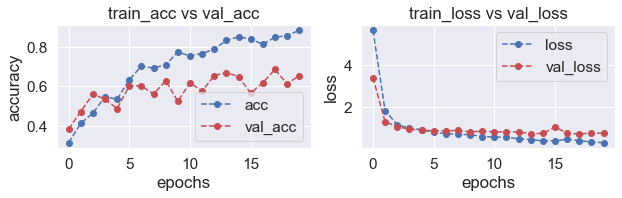

In [0]:
plot_accuracy_loss(history)

In [0]:
test_loss = model.evaluate(test_images, test_labels)

246/246 [==============================] - 4s 17ms/sample - loss: 1.5186 - acc: 0.6016


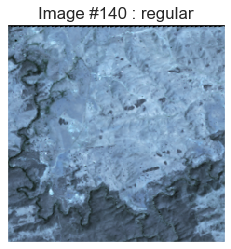

In [0]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

In [0]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


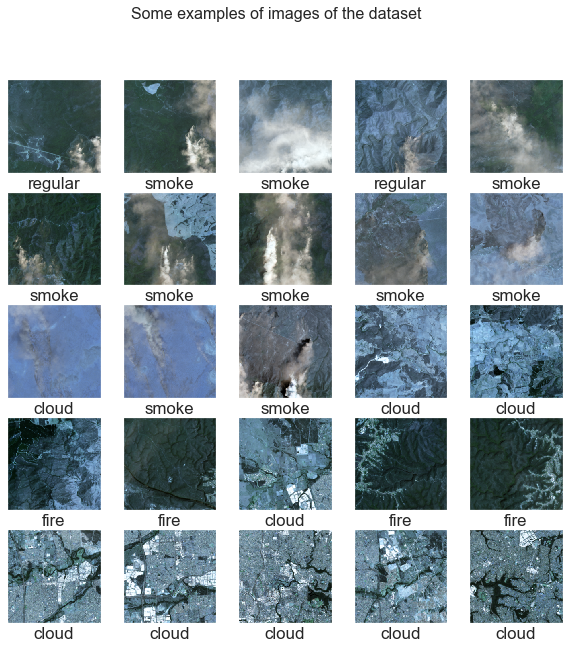

In [0]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)


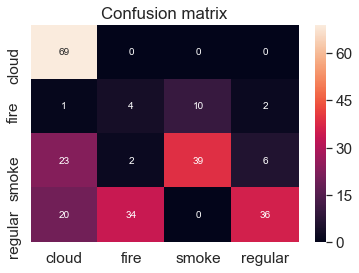

In [0]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

# Tansfer Learning

In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

Using TensorFlow backend.


In [0]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [0]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [0]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

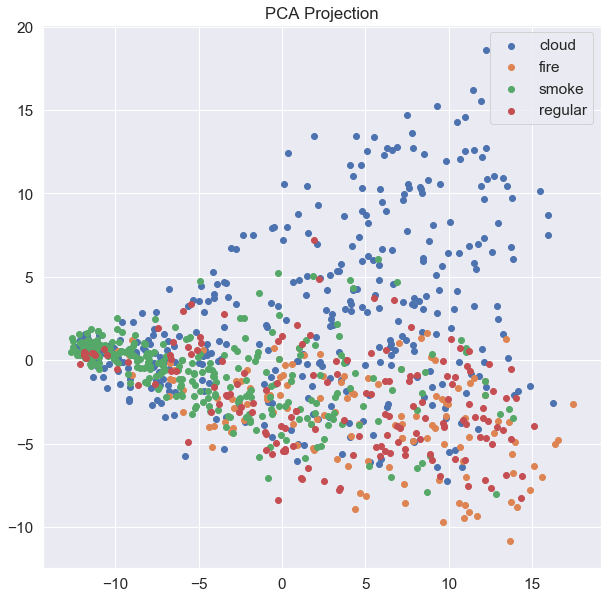

In [0]:

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name)
plt.legend()
plt.title("PCA Projection")
plt.show()

In [0]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Train on 764 samples, validate on 191 samples
Epoch 1/15
764/764 [==============================] - 1s 2ms/sample - loss: 1.9426 - acc: 0.3102 - val_loss: 1.3456 - val_acc: 0.4764
Epoch 2/15
764/764 [==============================] - 0s 501us/sample - loss: 1.1565 - acc: 0.4699 - val_loss: 1.0631 - val_acc: 0.5236
Epoch 3/15
764/764 [==============================] - 0s 602us/sample - loss: 1.0057 - acc: 0.5720 - val_loss: 0.9802 - val_acc: 0.6178
Epoch 4/15
764/764 [==============================] - 0s 542us/sample - loss: 0.8938 - acc: 0.6335 - val_loss: 0.9498 - val_acc: 0.5340
Epoch 5/15
764/764 [==============================] - 0s 547us/sample - loss: 0.8576 - acc: 0.6767 - val_loss: 0.8724 - val_acc: 0.7016
Epoch 6/15
764/764 [==============================] - 0s 516us/sample - loss: 0.7813 - acc: 0.6950 - val_loss: 0.8553 - val_acc: 0.6806
Epoch 7/15
764/764 [==============================] - 0s 618us/sample - loss: 0.7474 - acc: 0.7317 - val_loss: 0.8492 - val_acc: 0.6545
Epoc

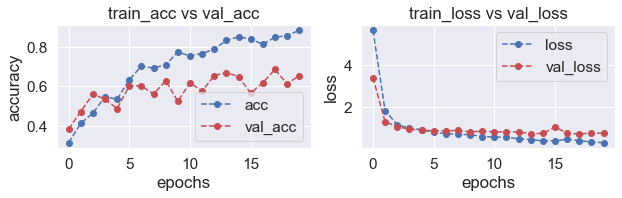

In [0]:
plot_accuracy_loss(history)

In [0]:
test_loss = model2.evaluate(test_features, test_labels)

246/246 [==============================] - 0s 405us/sample - loss: 0.7157 - acc: 0.7439


# Fine tune VGG 16

In [0]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [0]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [0]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (14, 14, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [0]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 14, 14, 512)       0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 64)          294976    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
__________

In [0]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 764 samples, validate on 191 samples
Epoch 1/10
764/764 [==============================] - 137s 179ms/step - loss: 2.3226 - acc: 0.2906 - val_loss: 1.4481 - val_acc: 0.3770
Epoch 2/10
764/764 [==============================] - 131s 171ms/step - loss: 1.2888 - acc: 0.4607 - val_loss: 1.1437 - val_acc: 0.4921
Epoch 3/10
764/764 [==============================] - 130s 171ms/step - loss: 1.1155 - acc: 0.4961 - val_loss: 1.0083 - val_acc: 0.5393
Epoch 4/10
764/764 [==============================] - 130s 171ms/step - loss: 0.9762 - acc: 0.5838 - val_loss: 0.9409 - val_acc: 0.5812
Epoch 5/10
764/764 [==============================] - 130s 170ms/step - loss: 0.8747 - acc: 0.6492 - val_loss: 0.8388 - val_acc: 0.6754
Epoch 6/10
764/764 [==============================] - 131s 171ms/step - loss: 0.7412 - acc: 0.7016 - val_loss: 0.7240 - val_acc: 0.6806
Epoch 7/10
764/764 [==============================] - 131s 171ms/step - loss: 0.6070 - acc

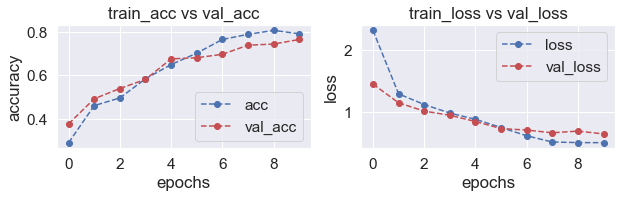

In [0]:
plot_accuracy_loss(history)

In [0]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.7154471544715447


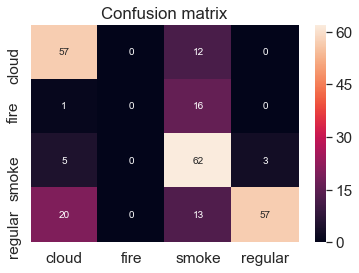

In [0]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

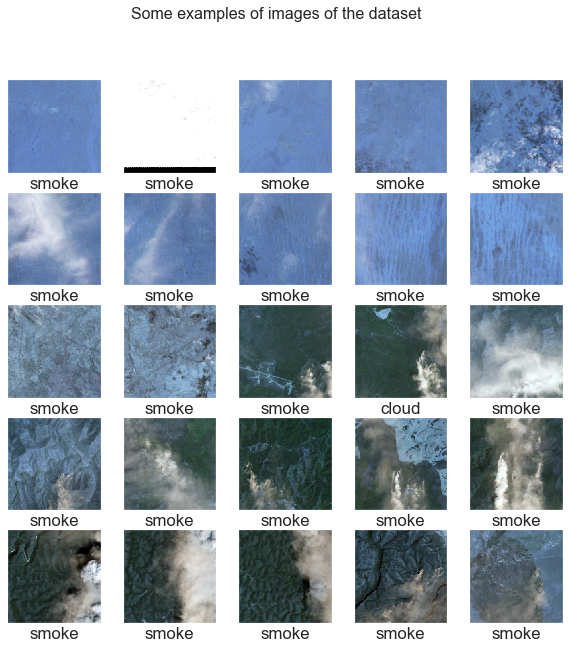

In [0]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)
